<h4>Install prophet + plotly for interactive plotting (interactive plots are laggy)

In [29]:
!pip install prophet


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
!pip install plotly


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL

f2021 = "../IT-NO_2021_hourly.csv"
f2022 = "../IT-NO_2022_hourly.csv"
f2023 = "../IT-NO_2023_hourly.csv"

dataset1 = pd.read_csv(f2021)
dataset2 = pd.read_csv(f2022)
dataset3 = pd.read_csv(f2023)

In [32]:
# Data concatenation of carbon intensity:
dataset_CI = pd.concat([dataset1, dataset2, dataset3], axis=0)

dataset_CI['Datetime (UTC)'] = pd.to_datetime(dataset_CI['Datetime (UTC)'])
dataset_CI.rename(columns={'Datetime (UTC)': 'timestamp'}, inplace=True) # Column renaming
dataset_CI.set_index('timestamp', inplace=True)

dataset_CI.drop(columns=['Country', 'Zone Name', 'Zone Id', 'Data Source', 'Data Estimated', 'Data Estimation Method', 'Low Carbon Percentage', 'Renewable Percentage'], inplace=True)
dataset_CI['LCA+direct'] = dataset_CI['Carbon Intensity gCO₂eq/kWh (LCA)'] + dataset_CI['Carbon Intensity gCO₂eq/kWh (direct)']
dataset_CI

,Carbon Intensity gCO₂eq/kWh (direct),Carbon Intensity gCO₂eq/kWh (LCA),LCA+direct
timestamp,,,
2021-01-01 00:00:00,303.29,389.74,693.03
2021-01-01 01:00:00,303.45,387.76,691.21
2021-01-01 02:00:00,295.04,377.86,672.90
2021-01-01 03:00:00,295.56,380.36,675.92
2021-01-01 04:00:00,308.06,394.66,702.72
...,...,...,...
2023-12-31 19:00:00,260.51,333.72,594.23
2023-12-31 20:00:00,265.88,342.93,608.81
2023-12-31 21:00:00,250.60,324.02,574.62


In [33]:
dataset_CI.drop(columns=['Carbon Intensity gCO₂eq/kWh (direct)', 'Carbon Intensity gCO₂eq/kWh (LCA)'], inplace=True)
dataset_CI

,LCA+direct
timestamp,
2021-01-01 00:00:00,693.03
2021-01-01 01:00:00,691.21
2021-01-01 02:00:00,672.90
2021-01-01 03:00:00,675.92
2021-01-01 04:00:00,702.72
...,...
2023-12-31 19:00:00,594.23
2023-12-31 20:00:00,608.81
2023-12-31 21:00:00,574.62


Testing prophet on LCA+direct datapoints. documentation: https://facebook.github.io/prophet/docs/quick_start.html#python-api
 

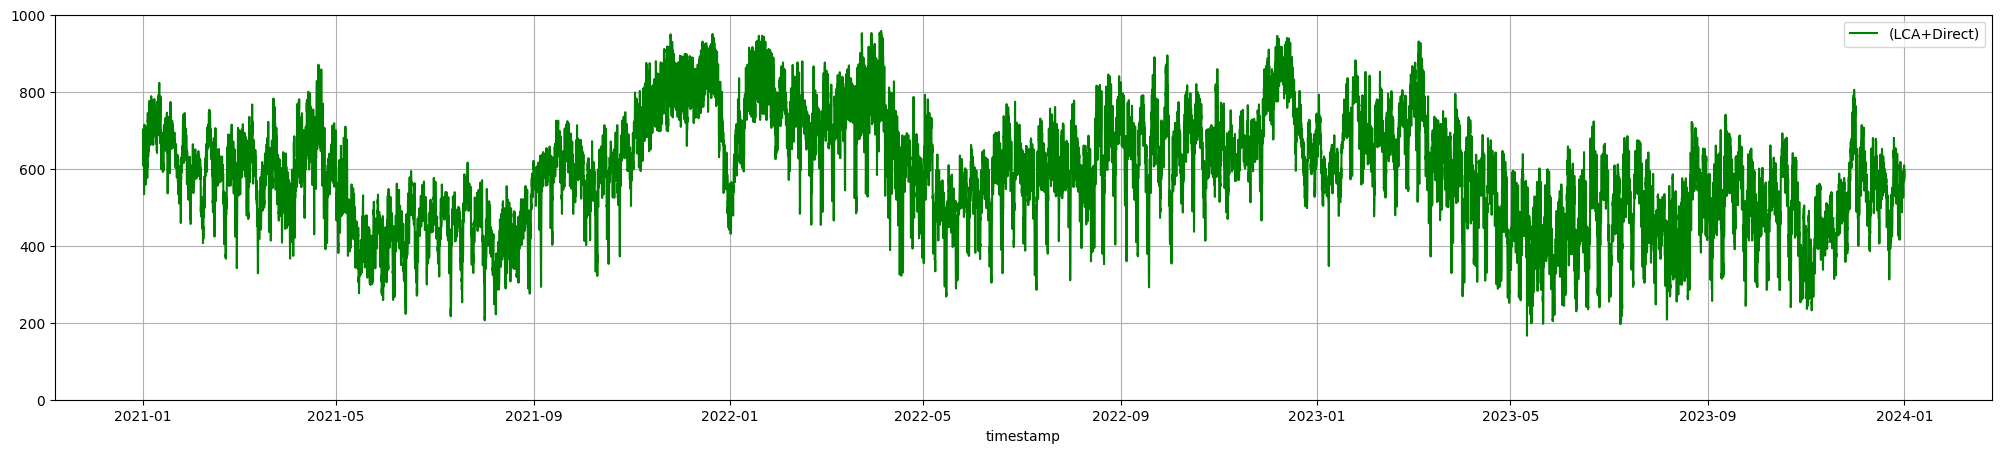

In [34]:
# Plotting and comparison od the different CI values
x = dataset_CI.index
y = dataset_CI['LCA+direct']

# Create subplots with shared X-axis
fig, ax1 = plt.subplots(1, 1, figsize=(25, 5), sharex=True)

# Plot data on each subplot

ax1.grid(True)
ax1.plot(x, y, 'g', label='(LCA+Direct)')
ax1.set_ylim(0, 1000)
ax1.set_xlabel('timestamp')

# Add legends

ax1.legend()

# Show the plot
plt.show()


Preparing the dataframe as required by the prophet documentation:

In [35]:
dataset_CI

,LCA+direct
timestamp,
2021-01-01 00:00:00,693.03
2021-01-01 01:00:00,691.21
2021-01-01 02:00:00,672.90
2021-01-01 03:00:00,675.92
2021-01-01 04:00:00,702.72
...,...
2023-12-31 19:00:00,594.23
2023-12-31 20:00:00,608.81
2023-12-31 21:00:00,574.62


In [36]:
dataset_CI_fix = dataset_CI.reset_index()
dataset_CI_fix

,timestamp,LCA+direct
0,2021-01-01 00:00:00,693.03
1,2021-01-01 01:00:00,691.21
2,2021-01-01 02:00:00,672.90
3,2021-01-01 03:00:00,675.92
4,2021-01-01 04:00:00,702.72
...,...,...
26275,2023-12-31 19:00:00,594.23
26276,2023-12-31 20:00:00,608.81
26277,2023-12-31 21:00:00,574.62
26278,2023-12-31 22:00:00,597.98


In [37]:
dataset_CI_fix.rename(columns={'timestamp':'ds', 'LCA+direct':'y' }, inplace=True)
dataset_CI_fix

,ds,y
0,2021-01-01 00:00:00,693.03
1,2021-01-01 01:00:00,691.21
2,2021-01-01 02:00:00,672.90
3,2021-01-01 03:00:00,675.92
4,2021-01-01 04:00:00,702.72
...,...,...
26275,2023-12-31 19:00:00,594.23
26276,2023-12-31 20:00:00,608.81
26277,2023-12-31 21:00:00,574.62
26278,2023-12-31 22:00:00,597.98


Creating another dataset with data only before 2023-01, to predict 2023 and see the performance and compare

In [38]:
dataset_half = dataset_CI_fix[(dataset_CI_fix['ds'] < '2023-01')]

In [39]:
dataset_half

,ds,y
0,2021-01-01 00:00:00,693.03
1,2021-01-01 01:00:00,691.21
2,2021-01-01 02:00:00,672.90
3,2021-01-01 03:00:00,675.92
4,2021-01-01 04:00:00,702.72
...,...,...
17515,2022-12-31 19:00:00,743.33
17516,2022-12-31 20:00:00,733.81
17517,2022-12-31 21:00:00,742.13
17518,2022-12-31 22:00:00,739.83


Performing prediction with Prophet:

11:14:08 - cmdstanpy - INFO - Chain [1] start processing
11:14:17 - cmdstanpy - INFO - Chain [1] done processing


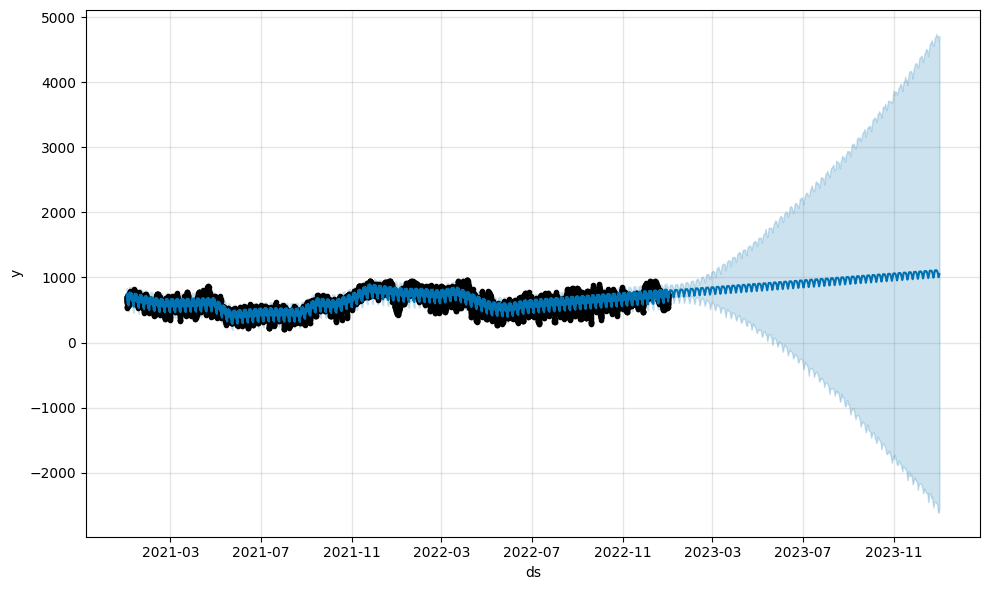

In [40]:
m_noparams = Prophet()
m_noparams.fit(dataset_half)

future = m_noparams.make_future_dataframe(periods=365) 
future.tail()

forecast_noparams = m_noparams.predict(future)
forecast_noparams[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m_noparams.plot(forecast_noparams)

Trying to adjust parameters to consider seasonalities:

11:14:23 - cmdstanpy - INFO - Chain [1] start processing
11:14:38 - cmdstanpy - INFO - Chain [1] done processing


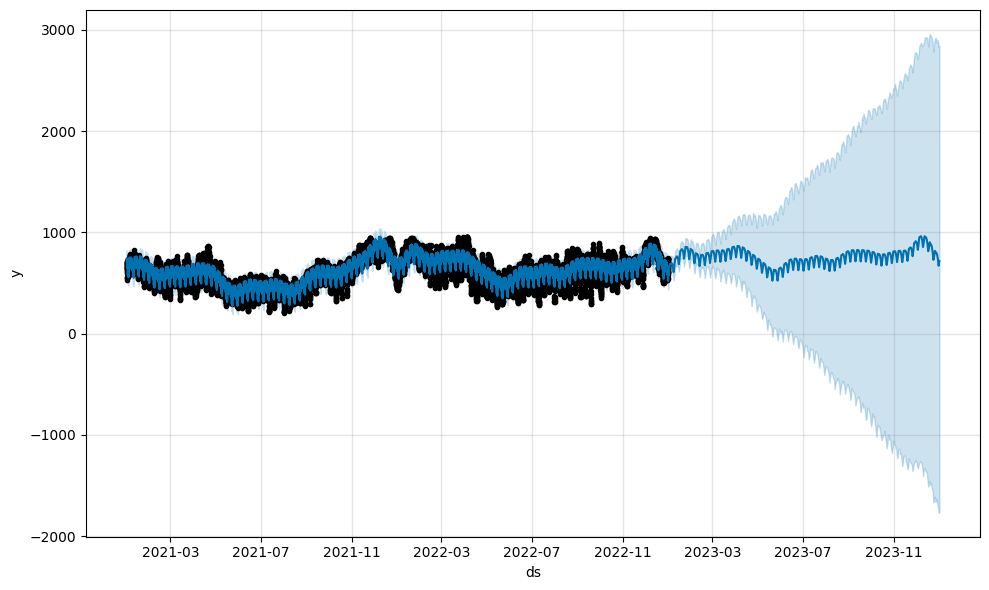

In [41]:
m = Prophet(yearly_seasonality = True, weekly_seasonality=True, daily_seasonality=True) # forcing to consider seasonality
m.fit(dataset_half)

future = m.make_future_dataframe(periods=365)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

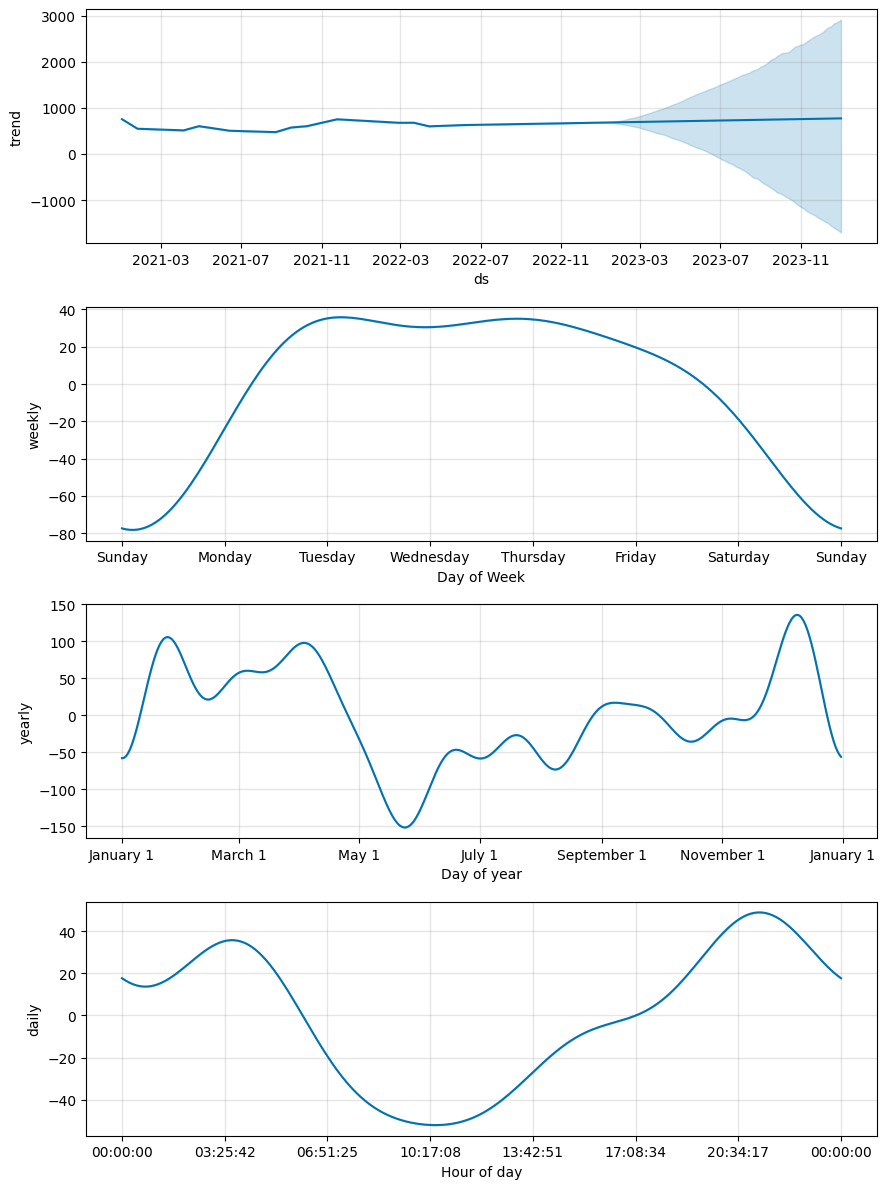

In [42]:
fig2 = m.plot_components(forecast)
plt.savefig('../PLOTS/CI_prophet.png', dpi=300) # Code to export the plot as an image

Now, looks better! Comparing with real data:

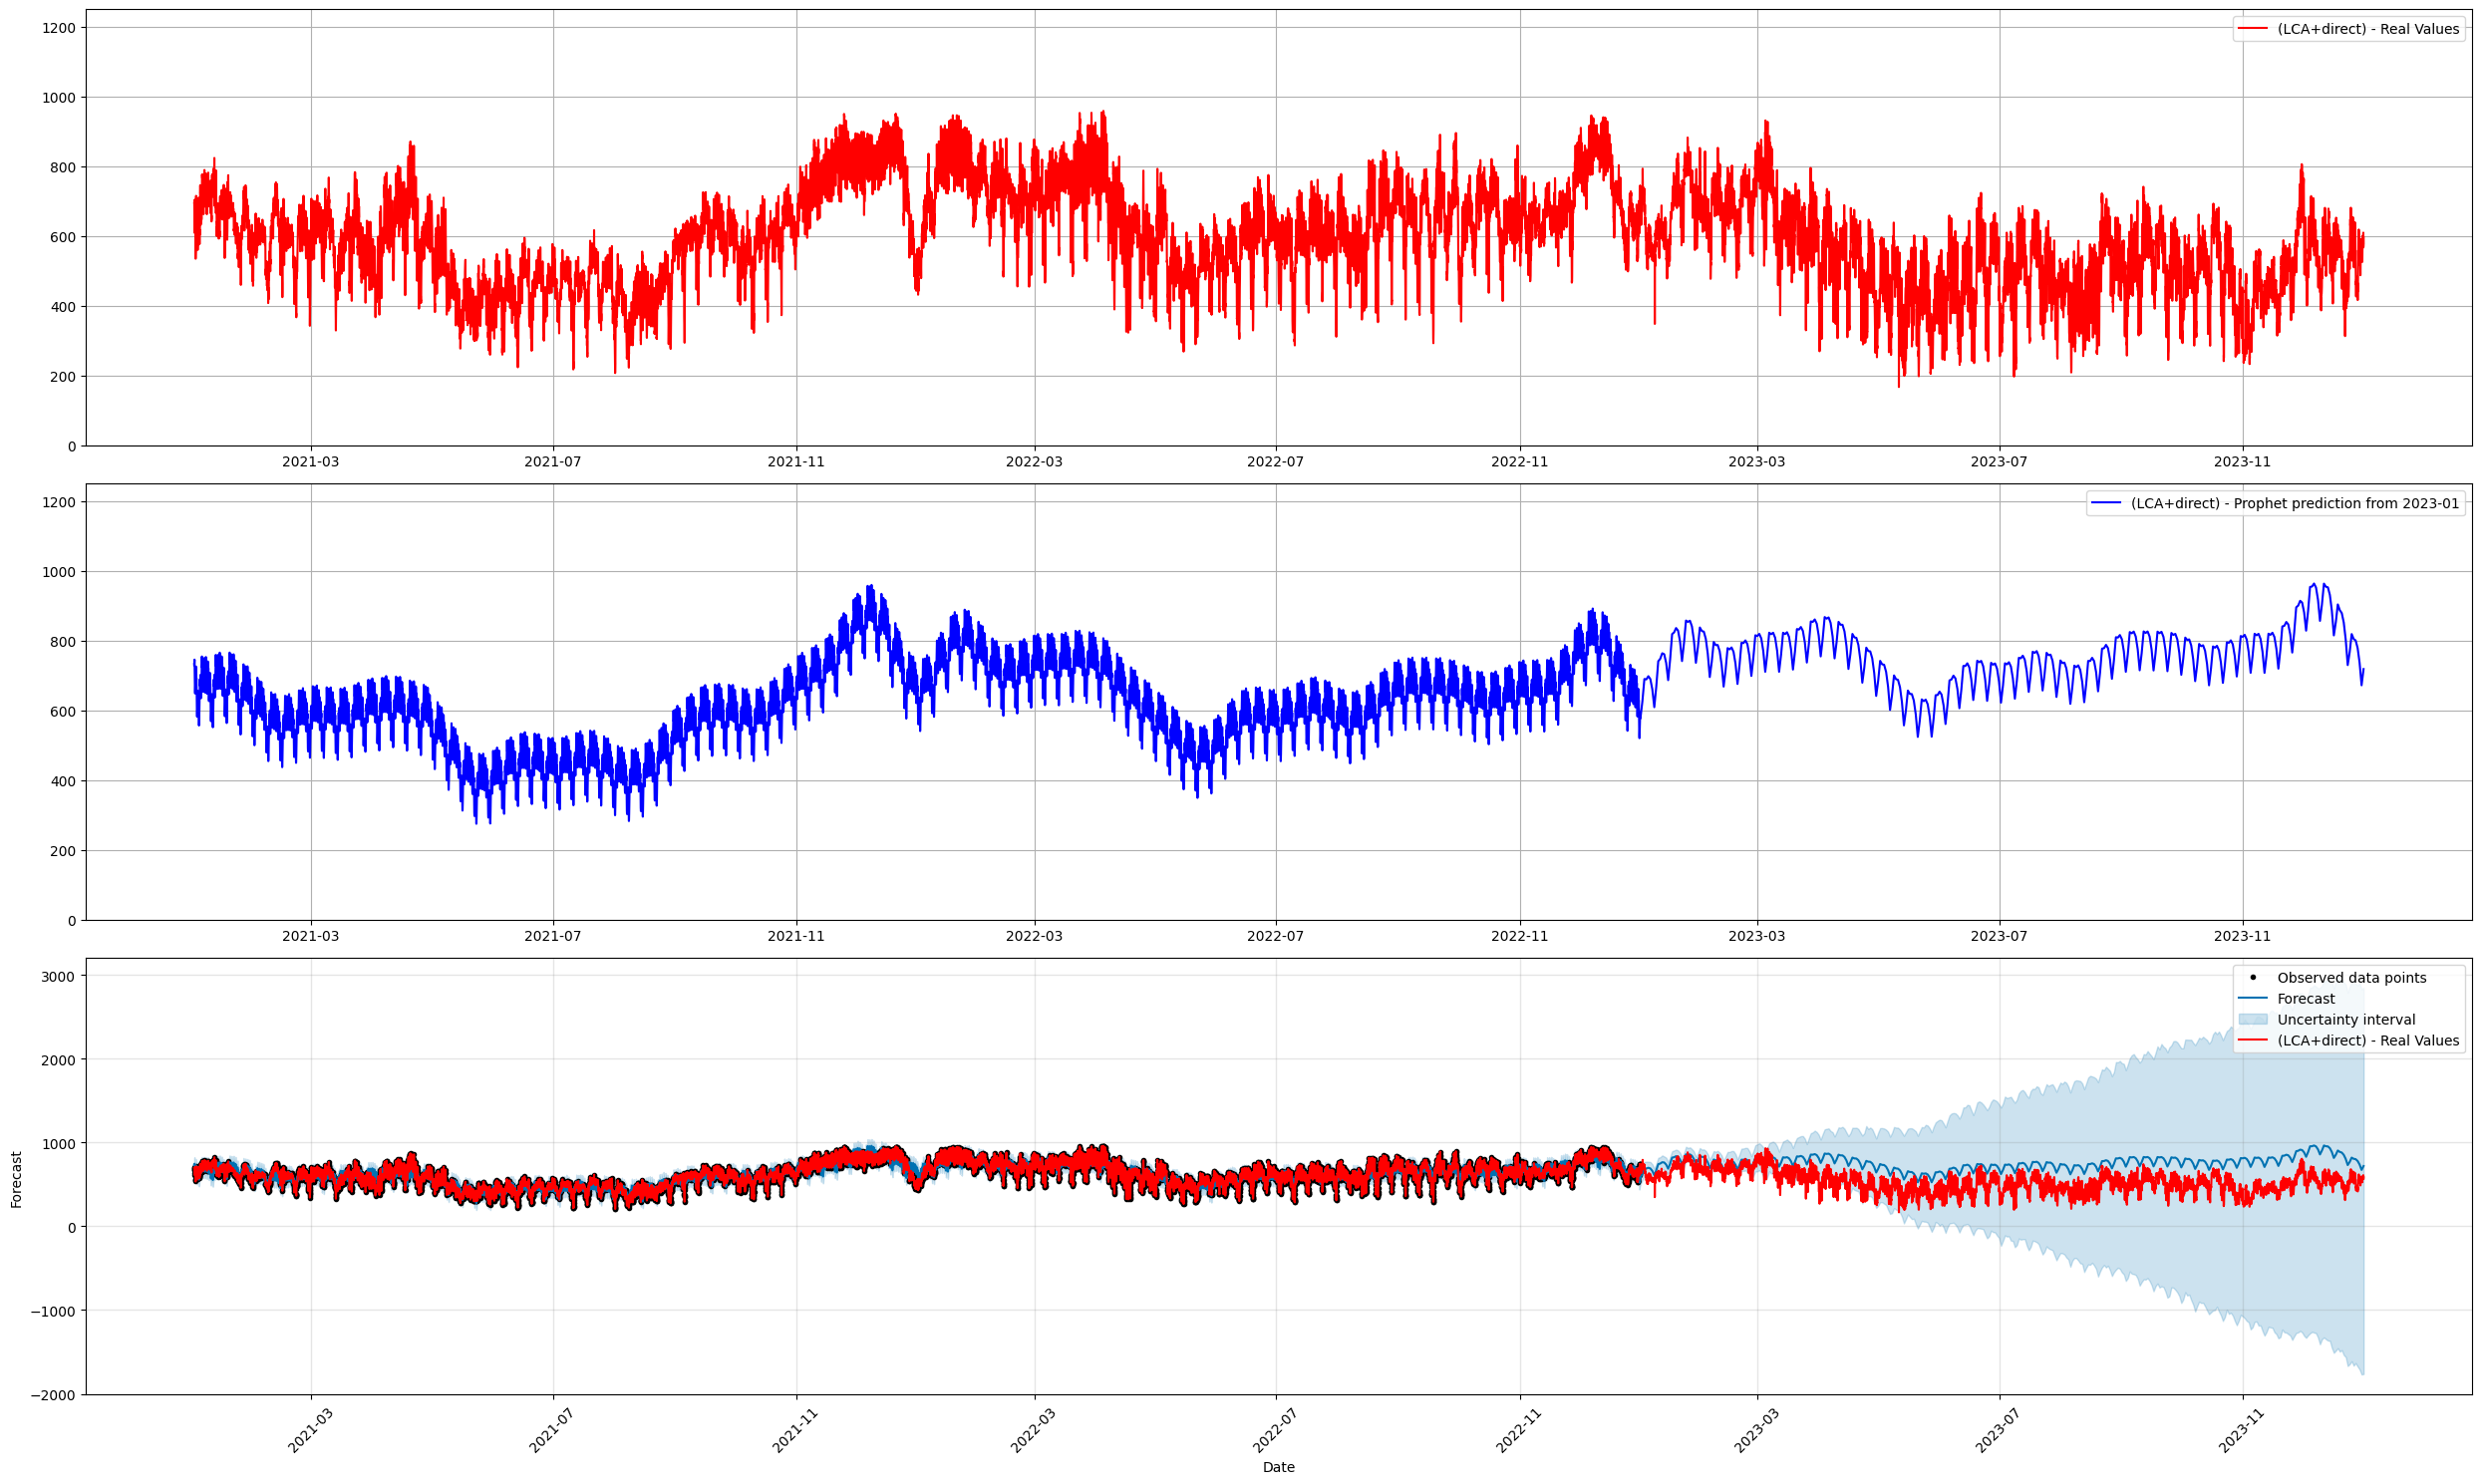

In [43]:
# datapoints:
x1 = dataset_CI.index
y1 = dataset_CI['LCA+direct']
x2 = forecast['ds']
y2 = forecast['yhat']

fig = plt.figure(figsize=(25, 15))  # Adjust the figure size as needed

# Create the first subplot
ax1 = fig.add_subplot(3, 1, 1)  # This will be the first subplot (3 rows, 1 column, first plot)
ax1.grid(True)
ax1.plot(x1, y1, 'red', label = '(LCA+direct) - Real Values')
ax1.set_ylim(0, 1250)

# Create the second subplot
ax2 = fig.add_subplot(3, 1, 2, sharex=ax1)  # This will be the second subplot
ax2.grid(True)
ax2.plot(x2, y2, 'blue', label = '(LCA+direct) - Prophet prediction from 2023-01')
ax2.set_ylim(0, 1250)

# Create the third subplot for Prophet's plot
ax3 = fig.add_subplot(3, 1, 3, sharex=ax1)  # This will be the third subplot
fig1 = m.plot(forecast, ax=ax3)  # Plot the forecast on the third subplot

ax3.plot(x1, y1, 'red', label = '(LCA+direct) - Real Values')

ax3.set_xlabel('Date')  # Set the x-axis label
ax3.set_ylabel('Forecast')  # Set the y-axis label
ax3.tick_params(axis='x', rotation=45)  # Optional: Rotate x-axis labels for better readability

ax1.legend()
ax2.legend()
ax3.legend()

plt.tight_layout()  # Adjust the layout so that plots do not overlap
plt.show()  # Display the figure

Zooming in into the prediction:

In [44]:
real_val = dataset_CI.reset_index()
real_val = real_val[(real_val['timestamp'] > '2023-01')].reset_index()
real_val = real_val[(real_val['timestamp'].dt.hour == 23)]
real_val = real_val.reset_index()

pred_val = forecast[(forecast['ds'] > '2023-01')]
pred_val = pred_val['yhat'].reset_index()

dataset_zoom = pd.concat([real_val, pred_val], axis = 1)
dataset_zoom.drop(columns=['level_0', 'index'], inplace = True)
dataset_zoom

,timestamp,LCA+direct,yhat
0,2023-01-01 23:00:00,704.02,625.837526
1,2023-01-02 23:00:00,712.77,689.872859
2,2023-01-03 23:00:00,545.69,688.752602
3,2023-01-04 23:00:00,598.14,697.880416
4,2023-01-05 23:00:00,578.56,689.824246
...,...,...,...
360,2023-12-27 23:00:00,521.19,800.387521
361,2023-12-28 23:00:00,442.08,778.858621
362,2023-12-29 23:00:00,525.04,736.415835
363,2023-12-30 23:00:00,588.19,671.872534


In [45]:
dataset_zoom['percerror'] = (abs(dataset_zoom['yhat']-dataset_zoom['LCA+direct'])/dataset_zoom['LCA+direct'])*100
dataset_zoom = dataset_zoom.set_index('timestamp')
dataset_zoom

,LCA+direct,yhat,percerror
timestamp,,,
2023-01-01 23:00:00,704.02,625.837526,11.105150
2023-01-02 23:00:00,712.77,689.872859,3.212417
2023-01-03 23:00:00,545.69,688.752602,26.216827
2023-01-04 23:00:00,598.14,697.880416,16.675096
2023-01-05 23:00:00,578.56,689.824246,19.231237
...,...,...,...
2023-12-27 23:00:00,521.19,800.387521,53.569240
2023-12-28 23:00:00,442.08,778.858621,76.180470
2023-12-29 23:00:00,525.04,736.415835,40.258996


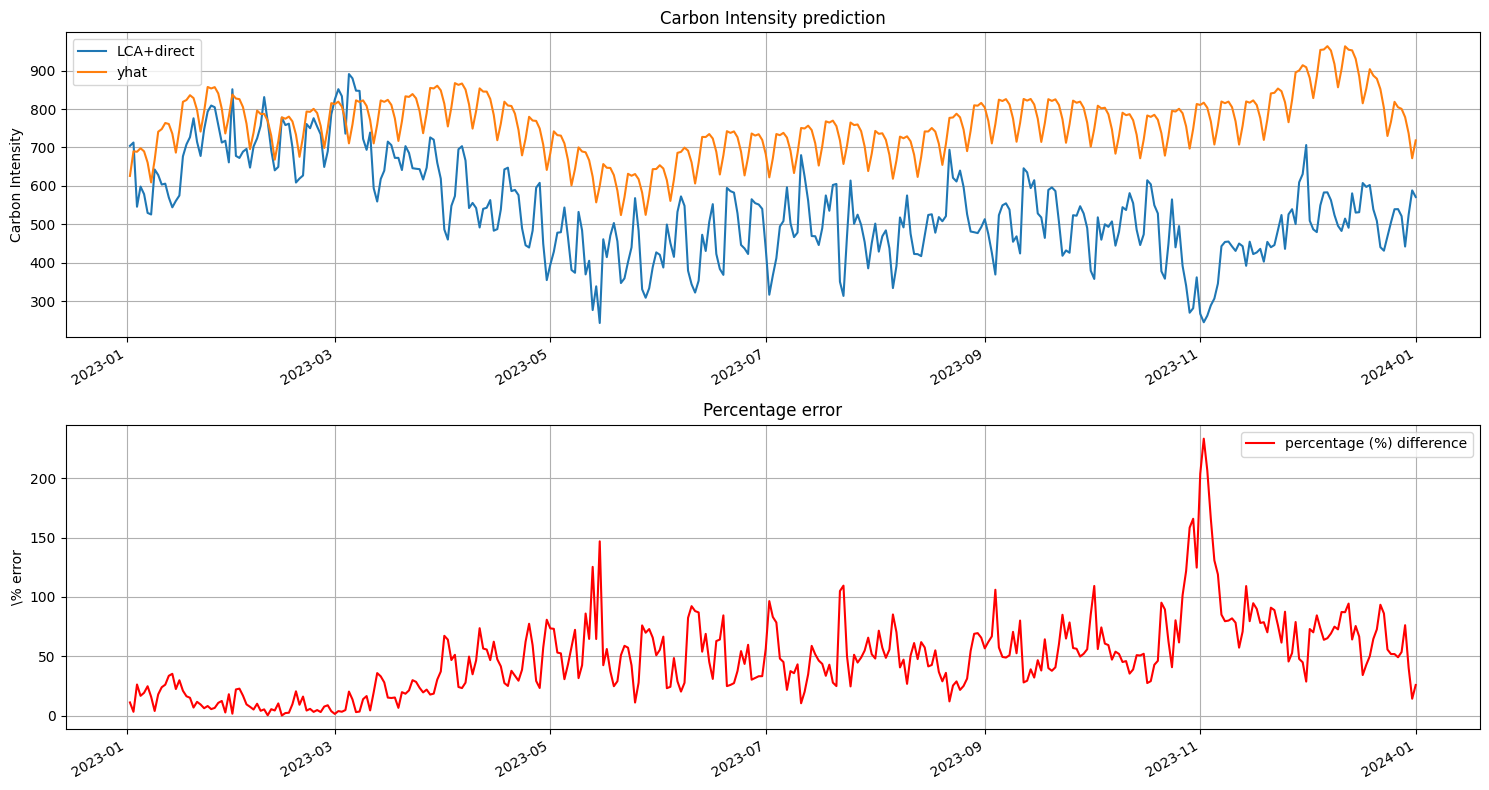

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Plot line1 and line2 on the first subplot
dataset_zoom[['LCA+direct', 'yhat']].plot(ax=ax1)
ax1.set_title('Carbon Intensity prediction')  # Set title for the first subplot
ax1.set_xlabel('')  # Set x-axis label for the first subplot
ax1.set_ylabel('Carbon Intensity')  # Set y-axis label for the first subplot
ax1.grid(True)  # Turn on grid for the first subplot

# Plot line3 on the second subplot
dataset_zoom['percerror'].plot(ax=ax2, color = 'red', label = 'percentage (%) difference')
ax2.set_title('Percentage error')  # Set title for the second subplot
ax2.set_xlabel('')  # Set x-axis label for the second subplot
ax2.set_ylabel('\% error')  # Set y-axis label for the second subplot
ax2.grid(True)  # Turn on grid for the second subplot
ax2.legend()
# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


<font color='red'>to-do:</color> It can be seen that the prediction gives larger error going further the year, so predicting on a smaller range (1month~few weeks better). (BD)

### Cop Analysis using Prophet

In [47]:
# Importing dataset
dataset_Cop = pd.read_csv('../Cop_Dataset.csv', index_col=0, parse_dates=True) 
dataset_Cop = dataset_Cop.sum(axis=1)

dataset_Cop

timestamp
2021-01-01 00:00:00    232459.597015
2021-01-01 01:00:00    240152.898959
2021-01-01 02:00:00    234486.053407
2021-01-01 03:00:00    240409.641951
2021-01-01 04:00:00    252919.407283
                           ...      
2022-09-28 18:00:00    316331.736829
2022-09-28 19:00:00    330324.063853
2022-09-28 20:00:00    340672.915831
2022-09-28 21:00:00    326630.447000
2022-09-28 22:00:00    318677.570400
Length: 15263, dtype: float64

In [48]:
dataset_Cop = dataset_Cop.reset_index()
dataset_Cop.rename(columns={'timestamp':'ds', 0:'y' }, inplace=True)

dataset_Cop

,ds,y
0,2021-01-01 00:00:00,232459.597015
1,2021-01-01 01:00:00,240152.898959
2,2021-01-01 02:00:00,234486.053407
3,2021-01-01 03:00:00,240409.641951
4,2021-01-01 04:00:00,252919.407283
...,...,...
15258,2022-09-28 18:00:00,316331.736829
15259,2022-09-28 19:00:00,330324.063853
15260,2022-09-28 20:00:00,340672.915831
15261,2022-09-28 21:00:00,326630.447000


11:14:48 - cmdstanpy - INFO - Chain [1] start processing
11:14:56 - cmdstanpy - INFO - Chain [1] done processing


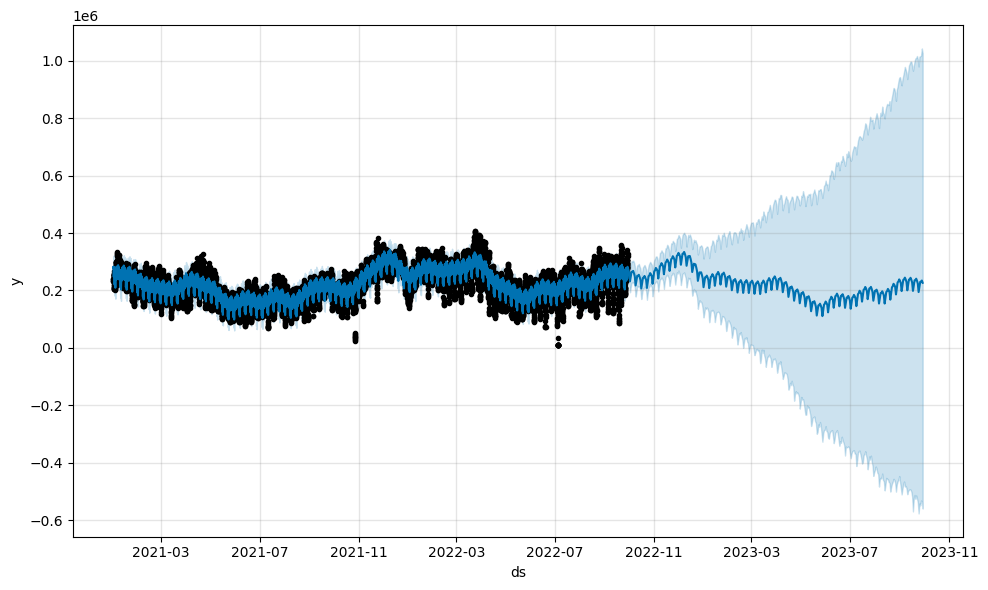

In [49]:
m = Prophet(yearly_seasonality = True, weekly_seasonality=True, daily_seasonality=True) # forcing to consider seasonality
m.fit(dataset_Cop)

future = m.make_future_dataframe(periods=365)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

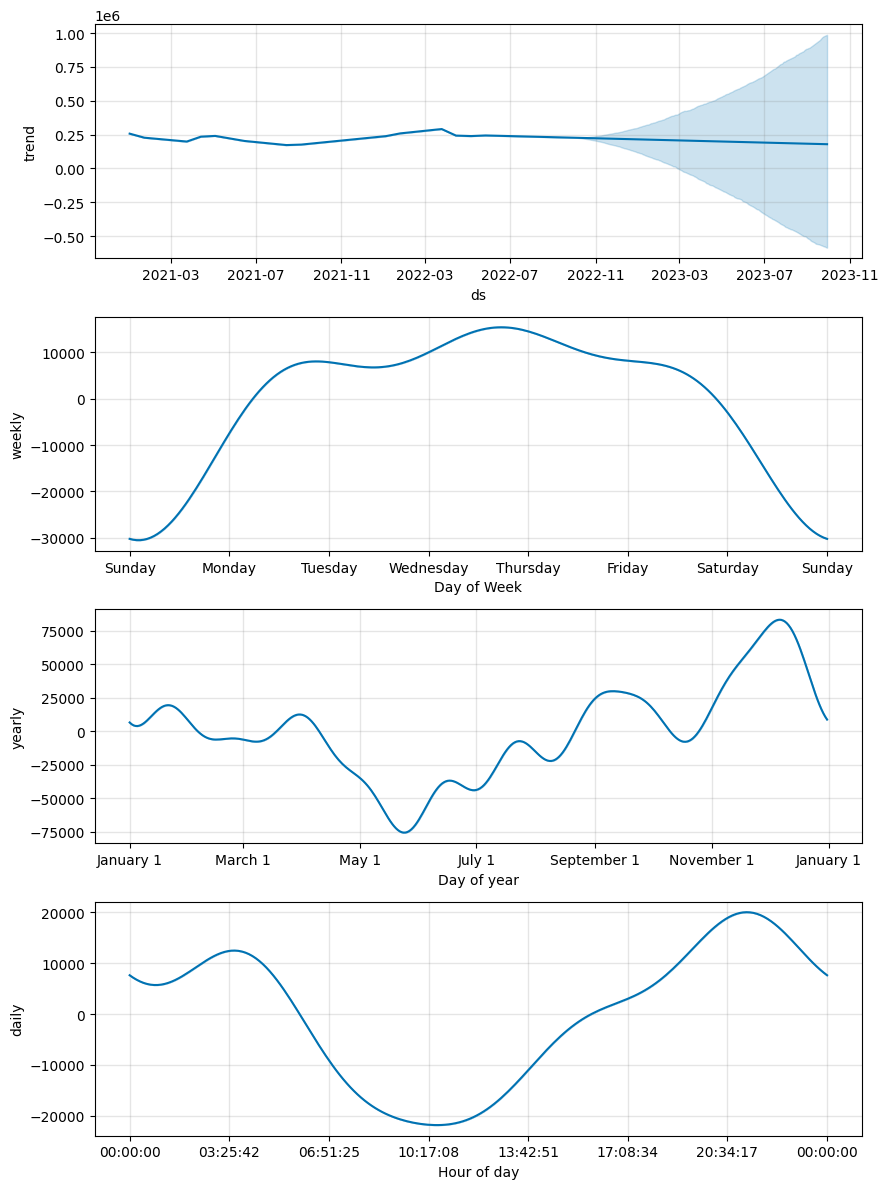

In [50]:
fig2 = m.plot_components(forecast)
plt.savefig('../PLOTS/Cop_prophet.png', dpi=300) # Code to export the plot as an image

### Power Analysis using Prophet

In [51]:
# Importing dataset
dataset_P = pd.read_csv('../PowerDataset_3_years.csv', index_col=0, parse_dates=True) 
dataset_P.index = pd.to_datetime(dataset_P.index).tz_localize(None) # To remove the localization in the datetime format
dataset_P = dataset_P.sum(axis=1)

dataset_P

timestamp
2020-05-02 17:00:00    637540.477086
2020-05-02 18:00:00    648837.510153
2020-05-02 19:00:00    608330.452245
2020-05-02 20:00:00    624141.382195
2020-05-02 21:00:00    654521.239171
                           ...      
2022-09-28 18:00:00    880386.676768
2022-09-28 19:00:00    880300.777778
2022-09-28 20:00:00    892000.722222
2022-09-28 21:00:00    847950.277778
2022-09-28 22:00:00    844940.000000
Length: 21102, dtype: float64

In [52]:
dataset_P = dataset_P.reset_index()
dataset_P.rename(columns={'timestamp':'ds', 0:'y' }, inplace=True)

dataset_P

,ds,y
0,2020-05-02 17:00:00,637540.477086
1,2020-05-02 18:00:00,648837.510153
2,2020-05-02 19:00:00,608330.452245
3,2020-05-02 20:00:00,624141.382195
4,2020-05-02 21:00:00,654521.239171
...,...,...
21097,2022-09-28 18:00:00,880386.676768
21098,2022-09-28 19:00:00,880300.777778
21099,2022-09-28 20:00:00,892000.722222
21100,2022-09-28 21:00:00,847950.277778


11:15:07 - cmdstanpy - INFO - Chain [1] start processing
11:15:15 - cmdstanpy - INFO - Chain [1] done processing


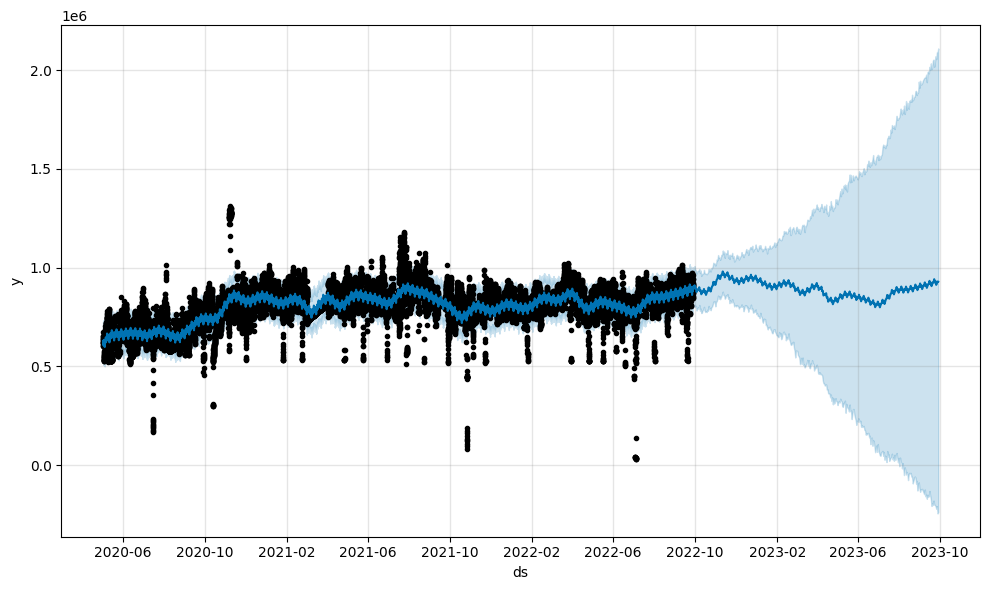

In [53]:
m = Prophet(yearly_seasonality = True, weekly_seasonality=True, daily_seasonality=True) # forcing to consider seasonality
m.fit(dataset_P)

future = m.make_future_dataframe(periods=365)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

In [54]:
fig2 = m.plot_components(forecast)
plt.savefig('../PLOTS/PWR_prophet.png', dpi=300) # Code to export the plot as an image